In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:

# mude pelo caminho onde se encontram os csv
folder_path = '/content/drive/MyDrive/ufmg/2025.1/cinema_ibd/saidas/'

In [19]:
import pandas as pd

df_pais_nulo = pd.read_csv(folder_path + 'filmes_sem_pais.csv')
df_nulos = pd.read_csv(folder_path + 'quantidade_nulos.csv')
df_filmes_pais = pd.read_csv(folder_path + 'filmes_por_pais.csv')
df_titulo_nulo = pd.read_csv(folder_path + 'titulo_brasil_nulos_por_pais.csv')

# 😔 De qual filme não temos a informação do país?

In [20]:
df_pais_nulo

,cpb_roe,titulo_original
0,E2400142000000,THE CHOSEN


Após breve pesquisa, foi possível descobrir que, na verdade, nesse caso, não foi um filme, mas sim a quarta temporada da série The Chosen que teve sessões especiais nos cinemas. Para constar, a série é uma produção estadunidense.

Para esse caso, poderíamos atribuir o valor Estados Unidos ou não informado em um atualização da tabela.

UPDATE public.filme SET pais_obra = 'NÃO INFORMADO' WHERE cpd_roe = 'E2400142000000' ;

🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄

UPDATE public.filme SET pais_obra = 'ESTADOS UNIDOS' WHERE cpd_roe = 'E2400142000000' ;

# 😋 Análises descritivas

In [21]:
df_nulos

,coluna,quantidade_nulos
0,cpb_roe,0
1,titulo_original,0
2,titulo_brasil,257
3,pais_obra,1


/tmp/ipython-input-22-1072224398.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coluna', y='quantidade_nulos', data=df_nulos, palette='pastel')


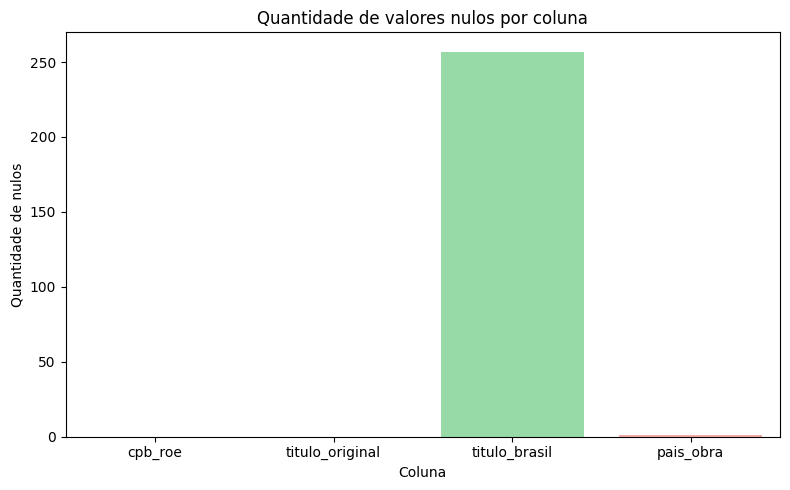

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(x='coluna', y='quantidade_nulos', data=df_nulos, palette='pastel')
plt.title('Quantidade de valores nulos por coluna')
plt.xlabel('Coluna')
plt.ylabel('Quantidade de nulos')
plt.tight_layout()
plt.show()

A partir dessa análise, conclui-se que, para além dos dados que, por definição, não podem ser nulos, a coluna discrepante é titulo_brasil, com mais de 250 linhas sem valor. Esse resultado é preocupante porque não sabemos a razão para ele acontecer: é um erro do dado? É algo que foi pensado para ser assim?

Primeiramente, vamos investigar quais os países das obras com valores nulos nessas colunas: Será que tem alguma relação?

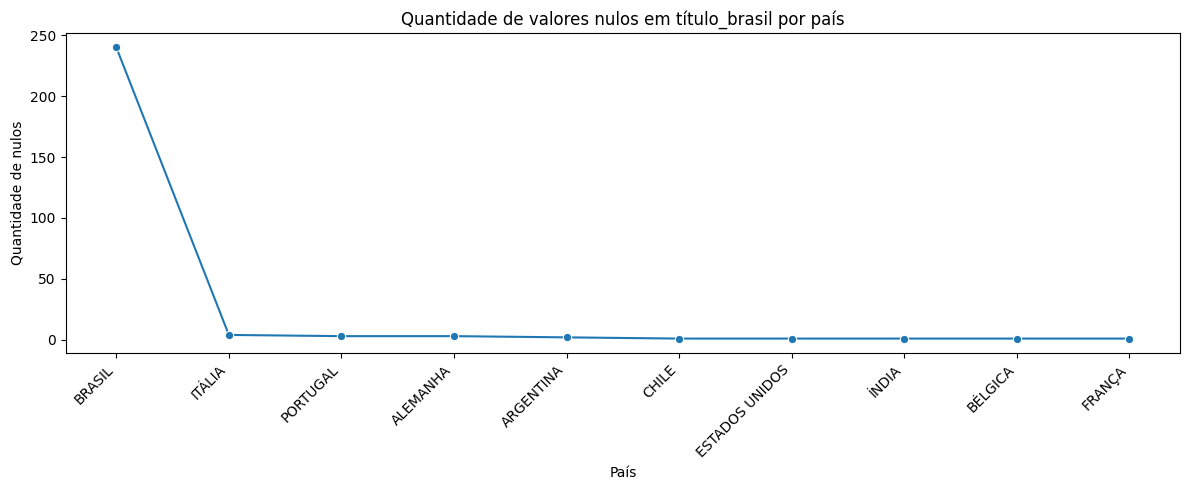

In [25]:
# Ordena do maior para o menor
df_titulo_nulo_sorted = df_titulo_nulo.sort_values(by='quantidade_com_titulo_brasil_nulo', ascending=False)

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_titulo_nulo_sorted, x='pais_obra', y='quantidade_com_titulo_brasil_nulo', marker='o')
plt.xticks(rotation=45, ha='right')
plt.title('Quantidade de valores nulos em título_brasil por país')
plt.xlabel('País')
plt.ylabel('Quantidade de nulos')
plt.tight_layout()
plt.show()

Claramente, os títulos que vem do Brasil, em grande parte, não possuem a coluna titulo_brasil completa. Vamos fazer uma comparação:

In [31]:
total_brasil = df_filmes_pais[df_filmes_pais['pais_obra'] == 'BRASIL']['quantidade_de_filmes'].values[0]
nulos_brasil = df_titulo_nulo[df_titulo_nulo['pais_obra'] == 'BRASIL']['quantidade_com_titulo_brasil_nulo'].values[0]

com_titulo_brasil = total_brasil - nulos_brasil
print(f'Filmes brasileiros com título_brasil preenchido: {com_titulo_brasil}')


Filmes brasileiros com título_brasil preenchido: 1


De fato, quase todo filme que vem do Brasil não tem título_brasil, já que seu valor seria igual a de titulo_original.

Consulta a ser feita para descobrir qual o 1 filmes brasileiro que tem titulo_brasil:
SELECT titulo_original, titulo_brasil FROM public.filme WHERE pais_obra = 'BRASIL' and titulo_brasil IS NOT NULL;

Essa consulta retorna o seguinte:

MY PENGUIN FRIEND |	MEU AMIGO PINGUIM

Pesquisando sobre o filme, descobri que  filme My Penguin Friend é uma coprodução brasileira e estadunidense, com distribuição internacional e elenco/maker técnicos voltados a um público global, e por isso o título está em inglês.

🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧

Um tratamento possível a ser feito aqui é copiar os valores de uma coluna para outra nos filmes brasileiros. Isso poderia ser feito com o comando SQL:

UPDATE public.filme
SET titulo_brasil = titulo_original
WHERE pais_obra = 'Brasil'
  AND titulo_brasil IS NULL;


A título de curiosidade, vou retirar os os filmes brasileiros para identificar as linhas que realmente são erros de inserção de dados e observar de onde vem as obras.

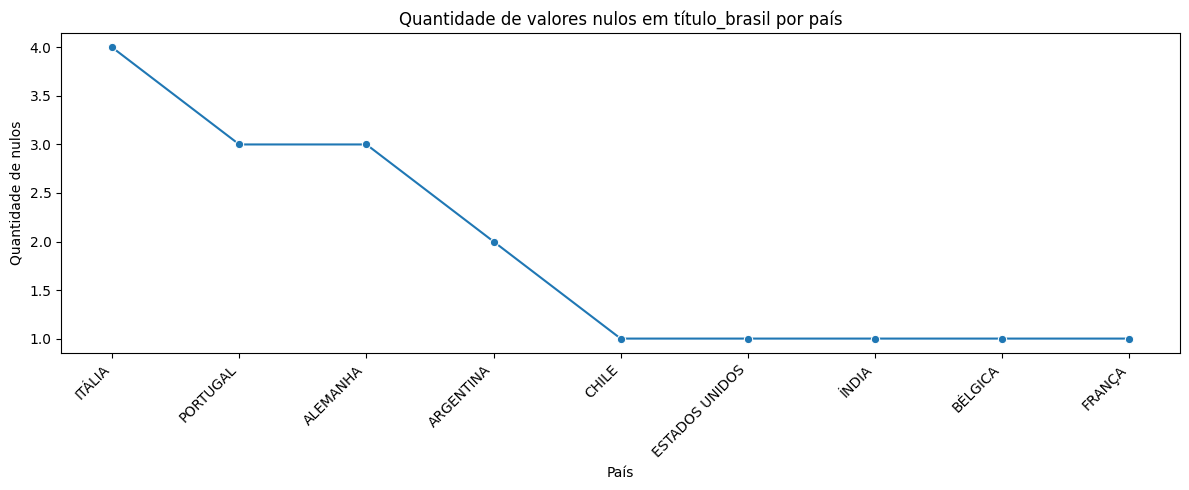

In [43]:
# Ordena do maior para o menor
df_titulo_nulo_sorted = df_titulo_nulo[df_titulo_nulo['pais_obra'] != 'BRASIL'].sort_values(by='quantidade_com_titulo_brasil_nulo', ascending=False)

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_titulo_nulo_sorted, x='pais_obra', y='quantidade_com_titulo_brasil_nulo', marker='o')
plt.xticks(rotation=45, ha='right')
plt.title('Quantidade de valores nulos em título_brasil por país')
plt.xlabel('País')
plt.ylabel('Quantidade de nulos')
plt.tight_layout()
plt.show()

Da mesma forma, como decisão de negócio, poderíamos realizar uma alteração atribuindo o titulo_original para titulo_brasil, para evitar valor nulo.

Comando:
UPDATE public.filme SET titulo_brasil = titulo_original WHERE titulo_brasil IS NULL;

In [44]:
!pip install pycountry plotly --quiet

import pycountry
import plotly.express as px

# Dicionário de tradução PT -> EN (pode adicionar mais se precisar)
traducao_paises = {
    'BRASIL': 'Brazil',
    'ESTADOS UNIDOS': 'United States',
    'FRANÇA': 'France',
    'ALEMANHA': 'Germany',
    'JAPÃO': 'Japan',
    'ESPANHA': 'Spain',
    'CANADÁ': 'Canada',
    'ITÁLIA': 'Italy',
    'REINO UNIDO': 'United Kingdom',
    'BÉLGICA': 'Belgium',
    'CORÉIA DO SUL': 'South Korea',
    'PORTUGAL': 'Portugal',
    'RÚSSIA': 'Russia',
    'INGLATERRA': 'United Kingdom',
    'AUSTRÁLIA': 'Australia',
    'CHILE': 'Chile',
    'ARGENTINA': 'Argentina',
    'CHINA': 'China',
    'IRÃ': 'Iran',
    'UCRÂNIA': 'Ukraine',
    'POLÔNIA': 'Poland',
    'SUÍÇA': 'Switzerland',
    'ÁFRICA DO SUL': 'South Africa',
    'NÃO INFORMADO': None,
    'ÍNDIA': 'India',
    'CAMBOJA': 'Cambodia',
    'GRÉCIA': 'Greece',
    'NOVA ZELÂNDIA': 'New Zealand',
    'HOLANDA': 'Netherlands',
    'NORUEGA': 'Norway',
    'URUGUAI': 'Uruguay',
    'BELARUS (BIELORUSSIA)': 'Belarus',
    'TURQUIA': 'Turkey',
    'PANAMÁ': 'Panama',
    'DINAMARCA': 'Denmark',
    'IRLANDA': 'Ireland',
    'TAILÂNDIA': 'Thailand',
    'ÁUSTRIA': 'Austria'
}


# Função que traduz e retorna o código
def get_country_code_ptbr(name):
    nome_ingles = traducao_paises.get(name, name)  # traduz se possível
    try:
        return pycountry.countries.lookup(nome_ingles).alpha_3
    except:
        return None

# Aplica a conversão
df_filmes_pais['iso_alpha'] = df_filmes_pais['pais_obra'].apply(get_country_code_ptbr)

# Remove países não encontrados
df_mundi = df_filmes_pais.dropna(subset=['iso_alpha'])

# Gera o mapa
fig = px.choropleth(df_mundi,
                    locations="iso_alpha",
                    color="quantidade_de_filmes",
                    hover_name="pais_obra",
                    color_continuous_scale="Blues",
                    title="Quantidade de Filmes exibidos nos cinemas brasileiros por País da obra")
fig.show()

# A imagem é iterativa. Para salvar como imagem, descomente o comando abaixo e coloque no caminho adequado.
# fig.write_image("quantidade_filmes_por_pais.png", width=1000, height=600)

A partir dessa análise, percebemos que o cinema brasileiro, em 2024 — mas que é um reflexo de uma tendência histórica ao longo dos anos — é fortemente concentrado em obras de origem brasileira e estadunidense. Essa predominância pode ser explicada por diversos fatores, como a proximidade cultural com a produção nacional, o incentivo de políticas públicas de fomento ao audiovisual local, além da hegemonia da indústria cinematográfica dos Estados Unidos, que domina o mercado internacional com grande força de distribuição e marketing. A baixa diversidade de países de origem nos filmes em cartaz no Brasil evidencia uma limitação no acesso a cinematografias alternativas, como a de países africanos, asiáticos ou mesmo latino-americanos, que acabam sendo pouco exibidas ou restritas a festivais e circuitos menores. Como consequência, o público brasileiro tende a ter seu repertório cultural limitado a narrativas e estéticas de poucos centros produtores, o que impacta diretamente na formação crítica e na valorização de outras perspectivas culturais. Essa concentração também dificulta a entrada de novas vozes no mercado, mantendo um ciclo onde apenas determinadas produções têm visibilidade e alcance comercial significativo.